## Import json files into pandas

In [29]:
# Load dependencies
import pandas as pd
import numpy as np
import json
import os
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import mpld3

In [16]:
# Read the directory with the data and save file_names in a list
path_to_json_files = 'data/'
json_files = [single_json for single_json in os.listdir(path_to_json_files) if single_json.endswith('.json')]

In [56]:
# Initiate an empty dataframe
main_df = pd.DataFrame()

# Feed the main_df with dataframes for each json file
for file_name in json_files:
    # Import the json and read it 
    with open(path_to_json_files+file_name) as json_data:
        d = json.load(json_data)
        for table_name in d.keys():
            d = d[table_name]
    
    # Load context into a pandas dataframe
    df_helper = pd.DataFrame(d)
    # Re-order the columns
    df_helper = df_helper.reindex_axis(['_id','name','created','delay','acceptable'],axis=1)
    # Add to the main_df each df created
    main_df = pd.concat([df_helper,main_df])

In [57]:
# Reset index of main_df
main_df = main_df.reset_index().drop('index',axis=1)

# Conver delay to int
main_df['delay']=main_df['delay'].astype(int)

In [58]:
main_df.head()

,_id,name,created,delay,acceptable
0,1,rickgrimes17,25/02/2017 10:33,780,1
1,2,rickgrimes17,25/02/2017 10:33,1349,1
2,3,rickgrimes17,25/02/2017 10:33,56,0
3,4,rickgrimes17,25/02/2017 10:33,201,1
4,5,rickgrimes17,25/02/2017 10:33,497,1


## Start the analysis

In [59]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 5 columns):
_id           537 non-null object
name          537 non-null object
created       537 non-null object
delay         537 non-null int64
acceptable    537 non-null object
dtypes: int64(1), object(4)
memory usage: 21.0+ KB


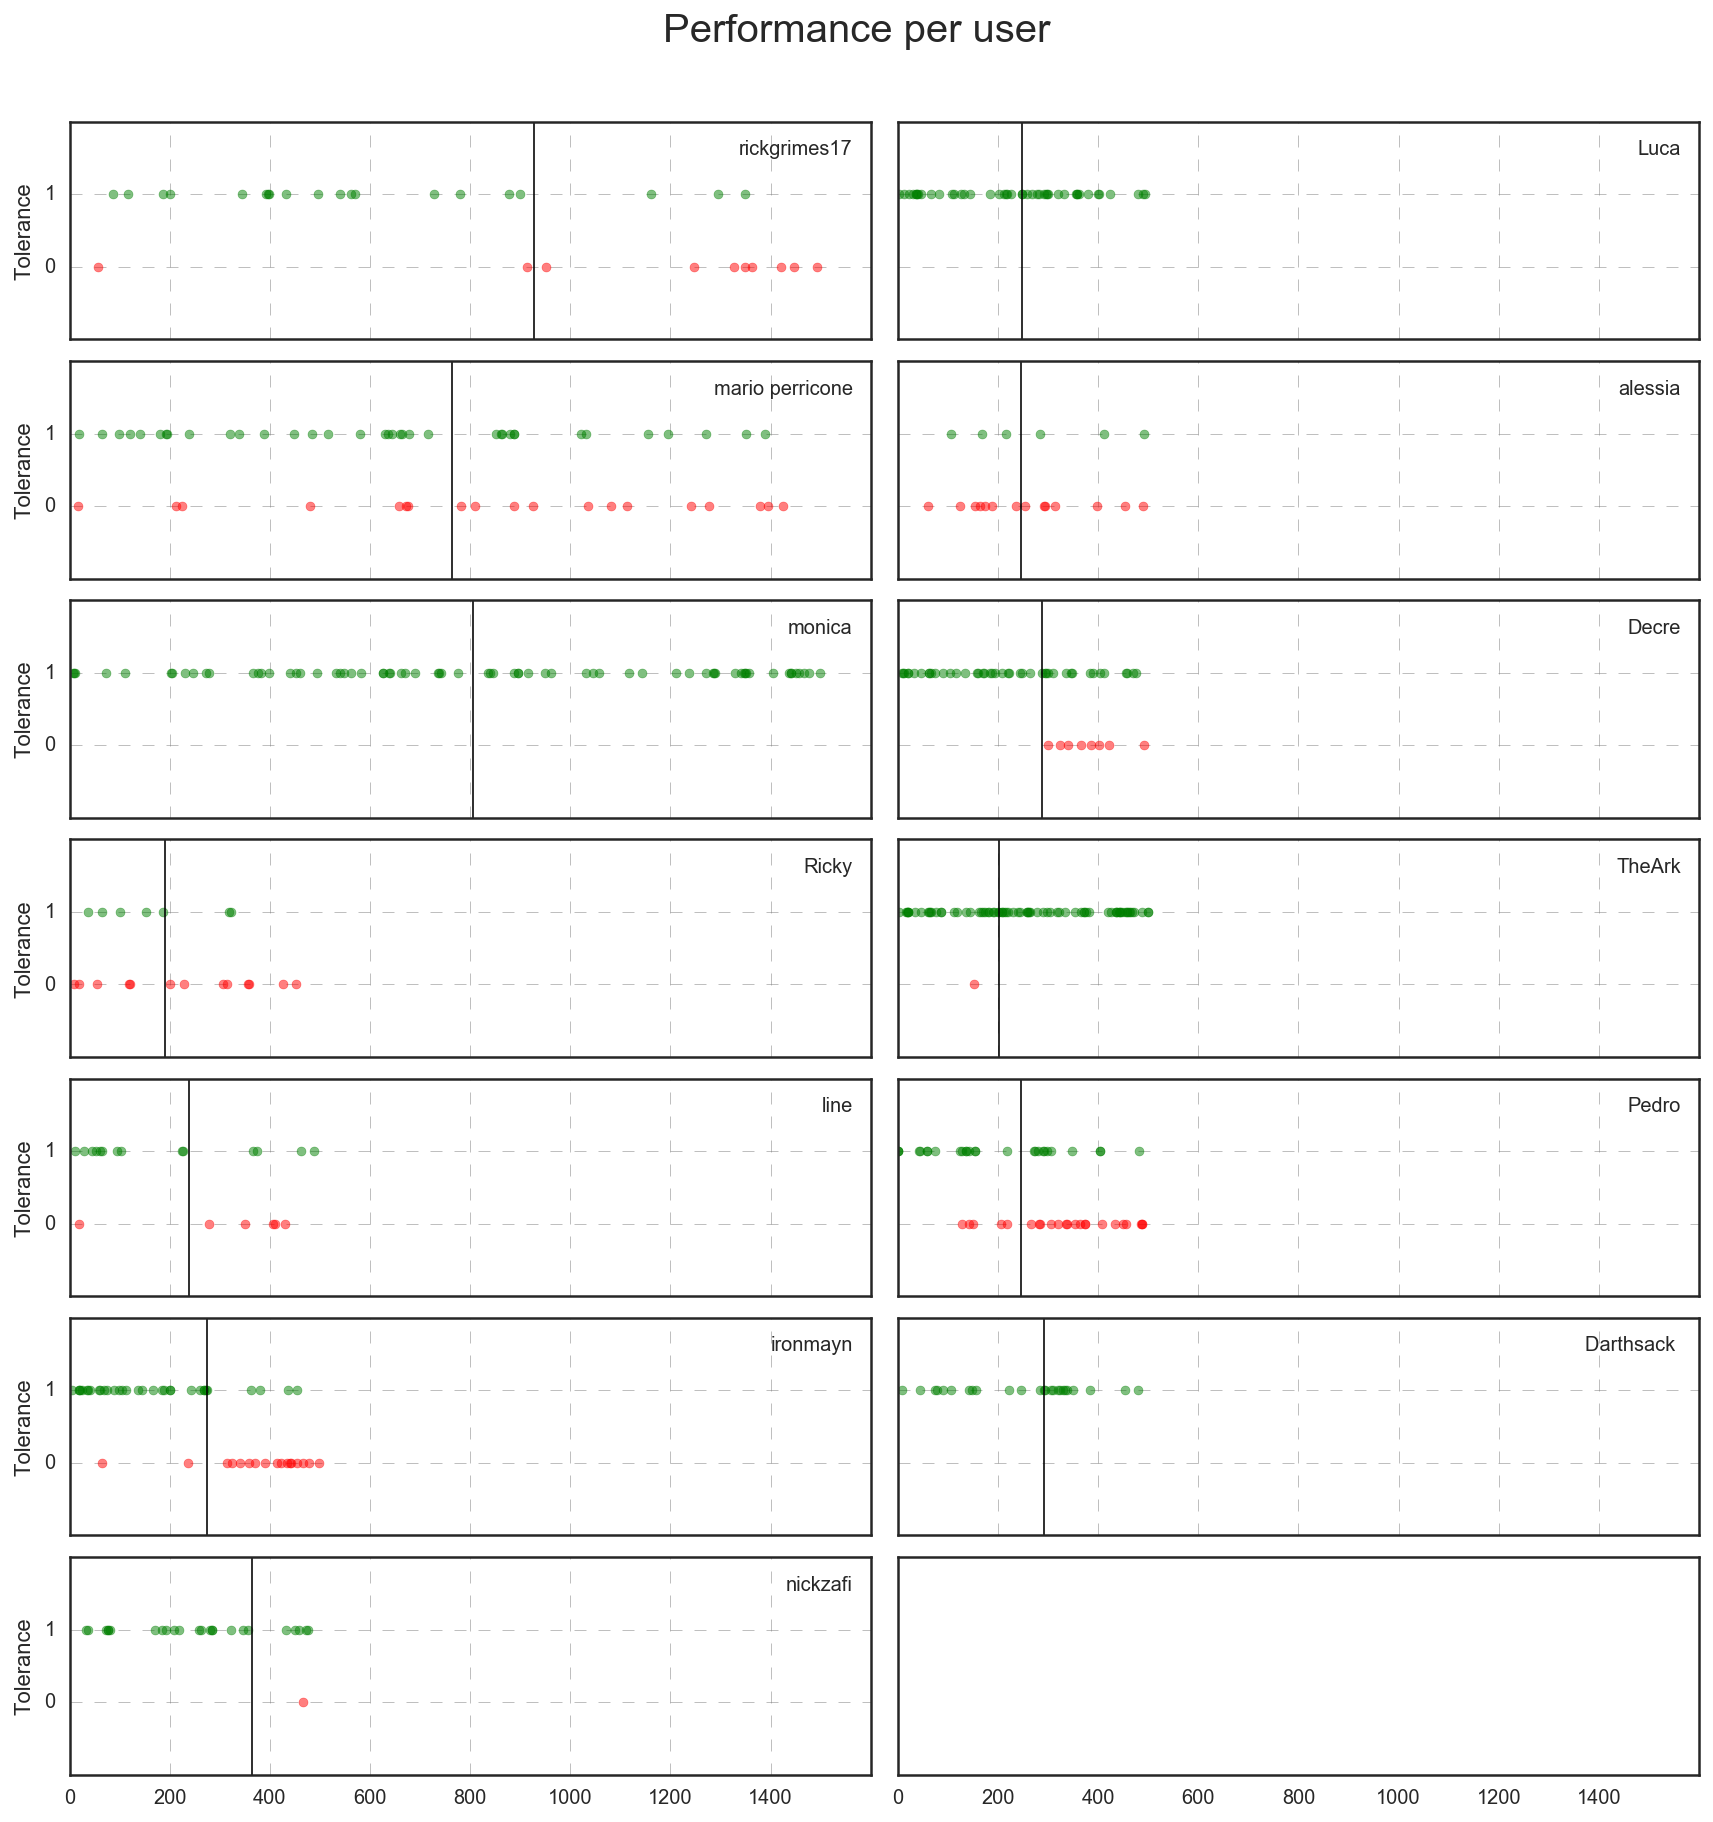

The average tolerance of all users is 391 ms


In [121]:
%config InlineBackend.figure_format = 'retina'
# create a list of thresholds in order to calculate the average tolerance of all users
thresholds = []

# use seaborn to set our graphing style. The style 'white' creates a white background for our graph
sns.set_style("white") 
# Assign variables to axes and figure
fig, ax = plt.subplots(nrows=7, ncols=2, sharex=True, sharey=True, figsize=(12, 12))

# Assign the size and the Super title
fig.suptitle('Performance per user', fontsize=20, y=1.05)

for index, name in enumerate(main_df['name'].unique()):
    # Create a sub-df for each name
    temp_df = main_df[main_df['name'] == name]

    # Drop column category from the new df to keep only year
    temp_df = temp_df.drop(['name','created','_id'], axis=1)  # axis=1 means column

    # Count frequency of crime occurence
    temp_df = temp_df.sort_values(by='acceptable', ascending=1)
    
    colors = ['red','green']
    # Assign x and y to subplots                   
    subindex = 0
    # Index < 7 means left column else right column
    if index < 7:
        final_index = index
        final_subindex = subindex
    else:
        final_index = index - 7
        final_subindex = subindex + 1
    
    # Create an ax object
    ax_temp =  ax[final_index][final_subindex]
    
    # Create a series of grey dashed lines across the each axis
    ax_temp.grid(axis='y',color='grey', linestyle='--', lw=0.5, alpha=0.5) 
    ax_temp.grid(axis='x',color='grey', linestyle='--', lw=0.5, alpha=0.5)  
    means = []
    # Plot each 0 or 1 with different colors
    for i in temp_df['acceptable'].unique():
        # Assign x and y values
        x = temp_df[temp_df['acceptable']==i]['delay']
        y = temp_df[temp_df['acceptable']==i]['acceptable'] 

        # If we don't have a value for y
        if len(y)==0:
            temp_mean = 0 # add 0
        else:
            temp_mean = np.median(x) # else keep the mean
            #print temp_mean
        means.append(temp_mean)
        
        # Feed the ax object with the x and y values
        ax_temp.scatter(x,y,alpha=.5, color=colors[int(i)],label=name)
    
    # Define x and y of threshold line
    threshold_x = [np.mean(means),np.mean(means)]
    threshold_y = [-1,2]
    thresholds.append(np.mean(means)) 
    
    # Plot the threshold line
    ax_temp.plot(threshold_x,threshold_y,'k-', lw=0.8)
    
    # Modify the legend
    ax_temp.legend([name],loc='upper right',frameon=False,handlelength=0, handletextpad=0)
    ax_temp.margins(0.01)

    if index < 7:
        ax_temp.set_ylabel("Tolerance")
            
    # Set xticks and yticks parameters
    plt.setp(ax, xticks=np.arange(0, 1600, 200),yticks=np.arange(0,2,1)) 
    ax_temp.set_ylim(-1, 2)
    ax_temp.set_xlim(0, 1600)
# Show the barplot
fig.tight_layout()
plt.show()
print 'The average tolerance of all users is %3.f ms' % np.mean(thresholds)